In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from keras.layers import Dense, Conv2D, LeakyReLU, Flatten, Dropout, Reshape, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import glob

In [3]:
#List all filename in art image path
img_size = (32, 32, 3)
filenames = glob.glob("Art_Image_dataset/**/**/*.jpg") + glob.glob("Art_Image_dataset/**/**/*.png")
# filenames= glob.glob("D:/work/Stuff/image_data_set_1/Original/*.jpg")

# read image from dataset and resize to
train_dataset = []
for filename in filenames :
    try:
        temp_img = cv.imread(filename)
        temp_img = cv.cvtColor(cv.resize(temp_img, img_size[:2], interpolation=cv.INTER_LINEAR), cv.COLOR_BGR2RGB)
        temp_img = np.interp(temp_img, (0, 255), (-1, 1))
        train_dataset.append(temp_img)
    except Exception as e :
        pass
train_dataset = np.asarray(train_dataset)
print(train_dataset.shape)

(3277, 32, 32, 3)


In [4]:
# Random Selected images
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples) # random image index
    # retrieve selected images
    X = dataset[ix] # get image from random pick ix
    # generate y = 1 for 'real' class labels
    y = np.zeros((n_samples, 1))
    return X, y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

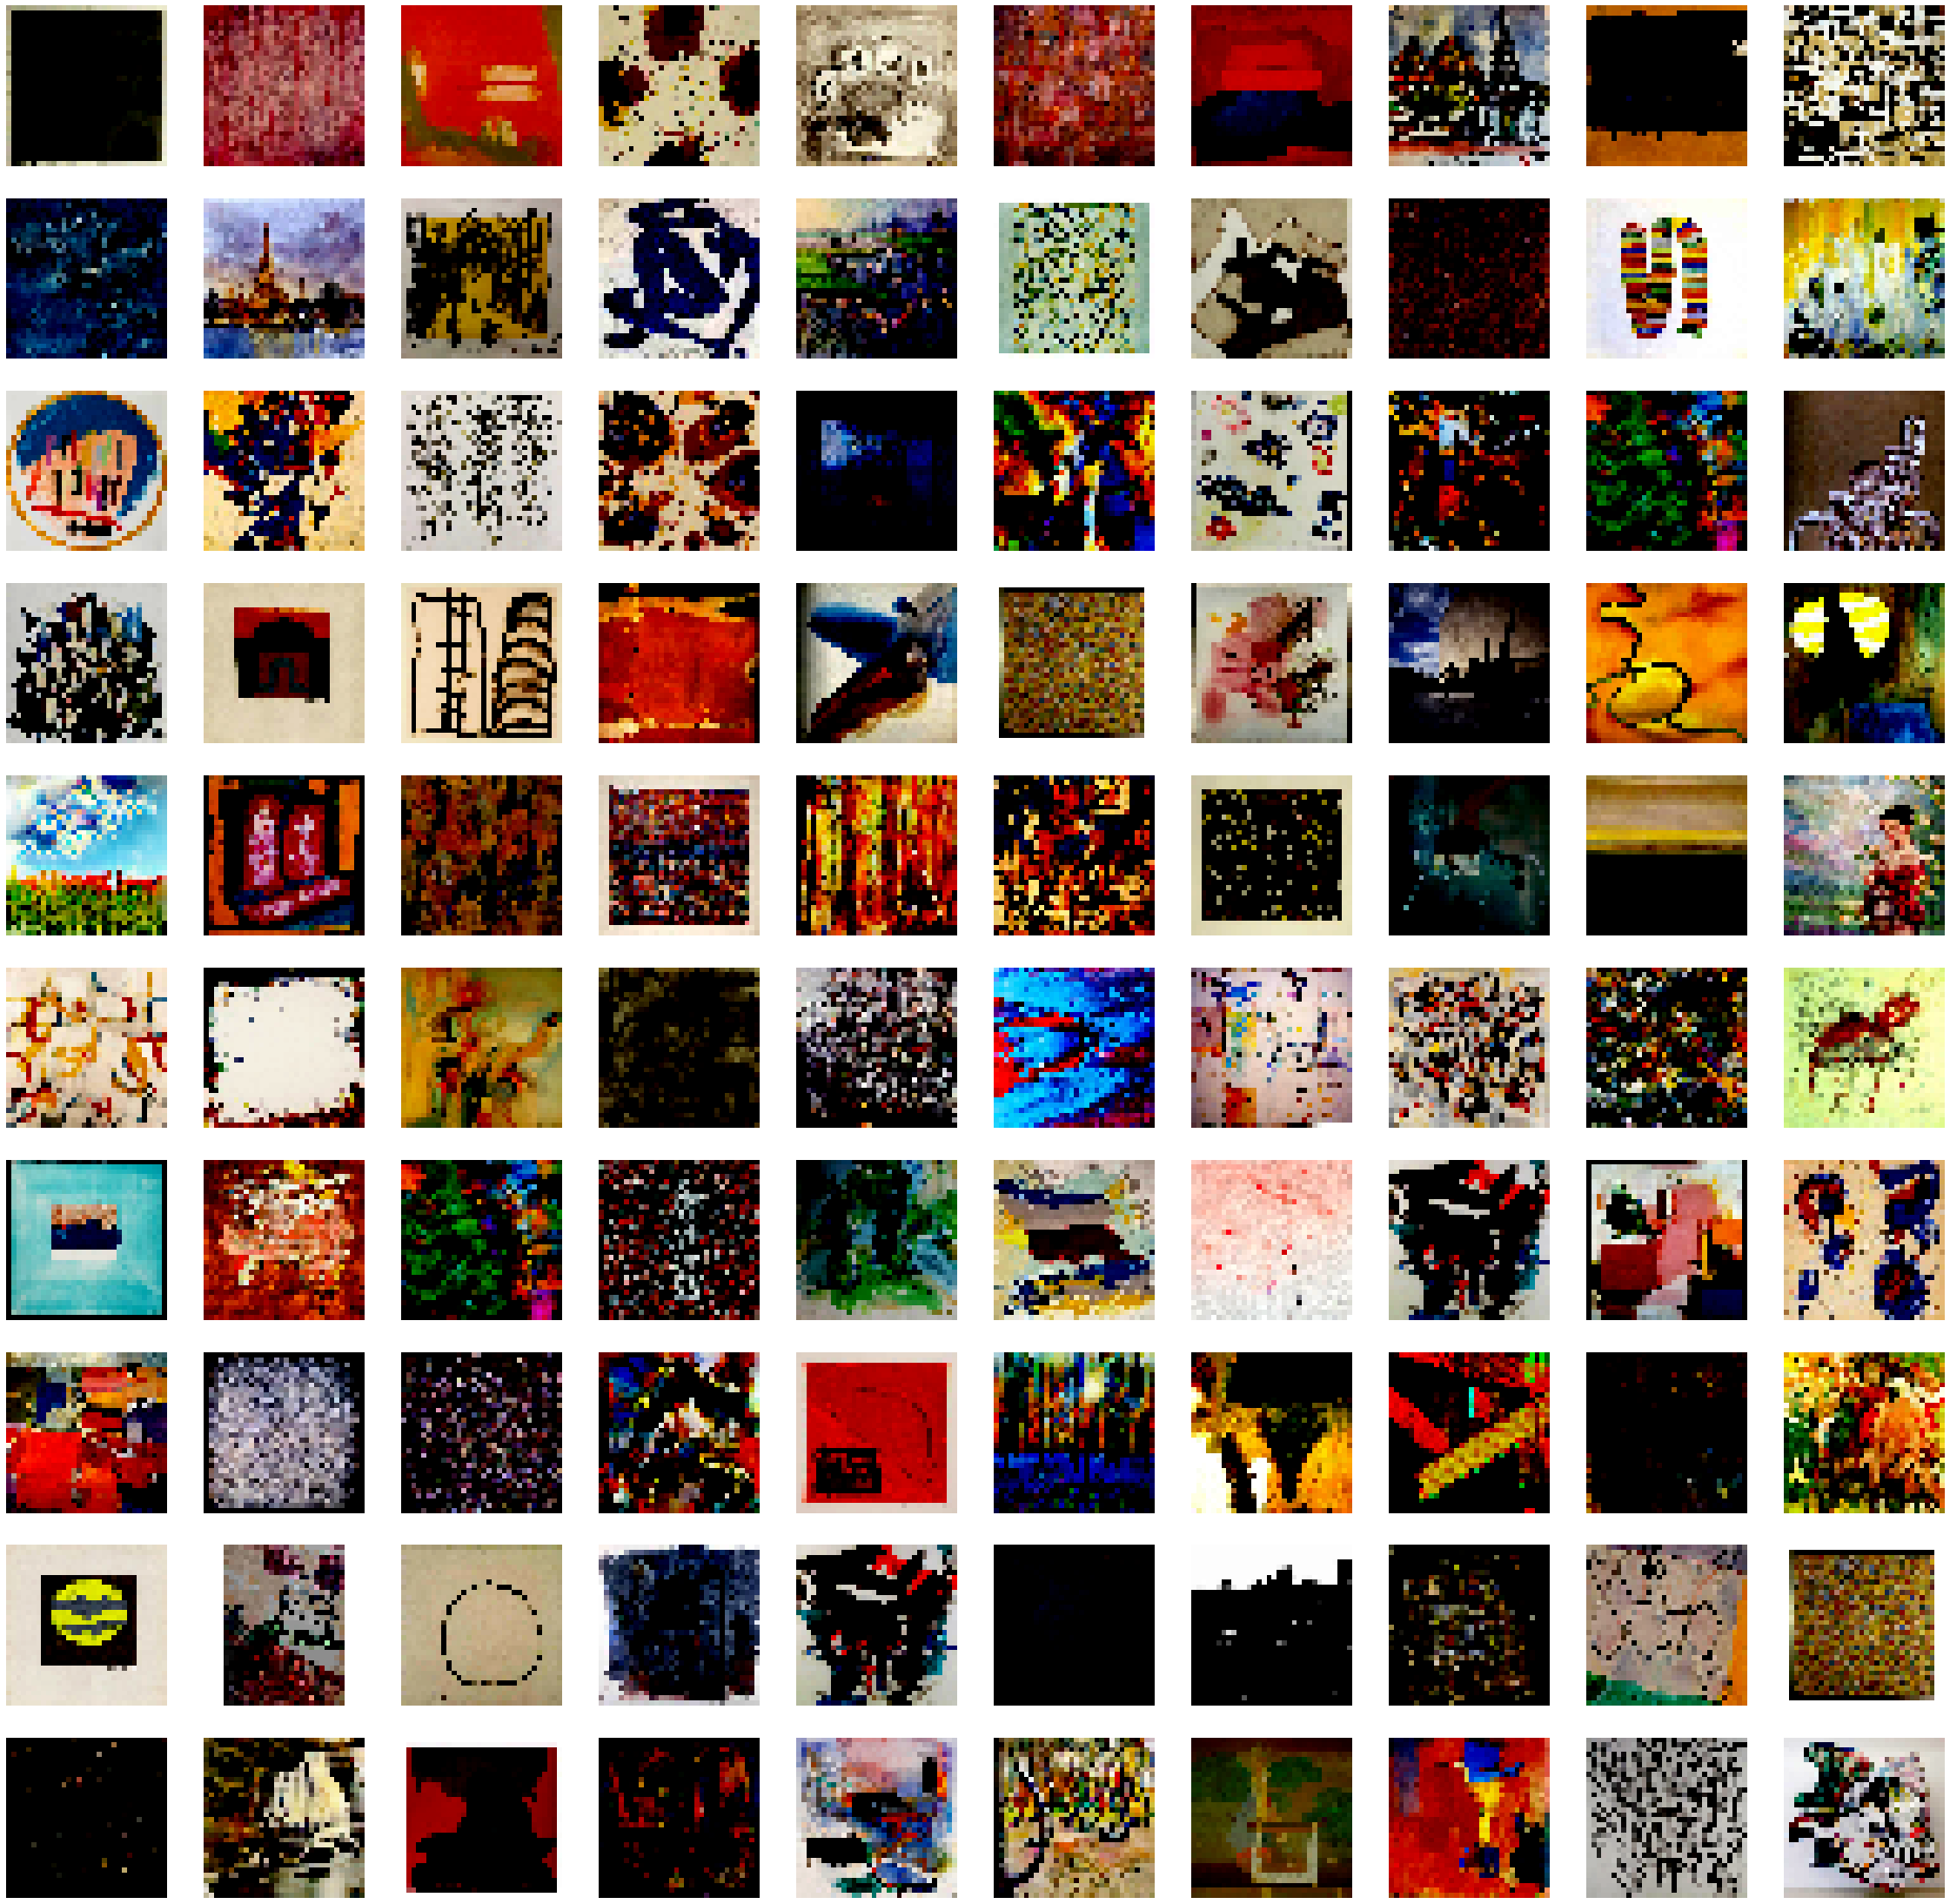

In [5]:
# Display Random Real Images
X_real, y_real = generate_real_samples(train_dataset, 100)

plt.rcParams['figure.figsize'] = [40, 40]
for i in range(100) :
    plt.subplot(10, 10, i + 1)
    plt.imshow(X_real[i])
    plt.axis('off')
plt.show()

In [6]:
def generate_fake_samples(n_samples, target_size=(32,32,3)):
    h, w, c = target_size
    # generate 1D uniform random numbers in [0,1]
    X = np.random.rand(n_samples * h * w * 3) #-> X.shape = (n_samples * h * w * 3)
    # rescale X value from [0, 1] to [-1, 1]
    X = np.interp(X, (0, 1), (-1, 1))# Xmax = 1, Xmin = -1
    # reshape X from 1D to 4D
    X = np.reshape(X, (n_samples, h, w, c)) # X.shape = (n_samples, h, w, c)
    # generate y = 0 for 'fake' class label
    y = np.zeros((n_samples, 1)) # y.shape = (n_samples,1)
    return X, y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

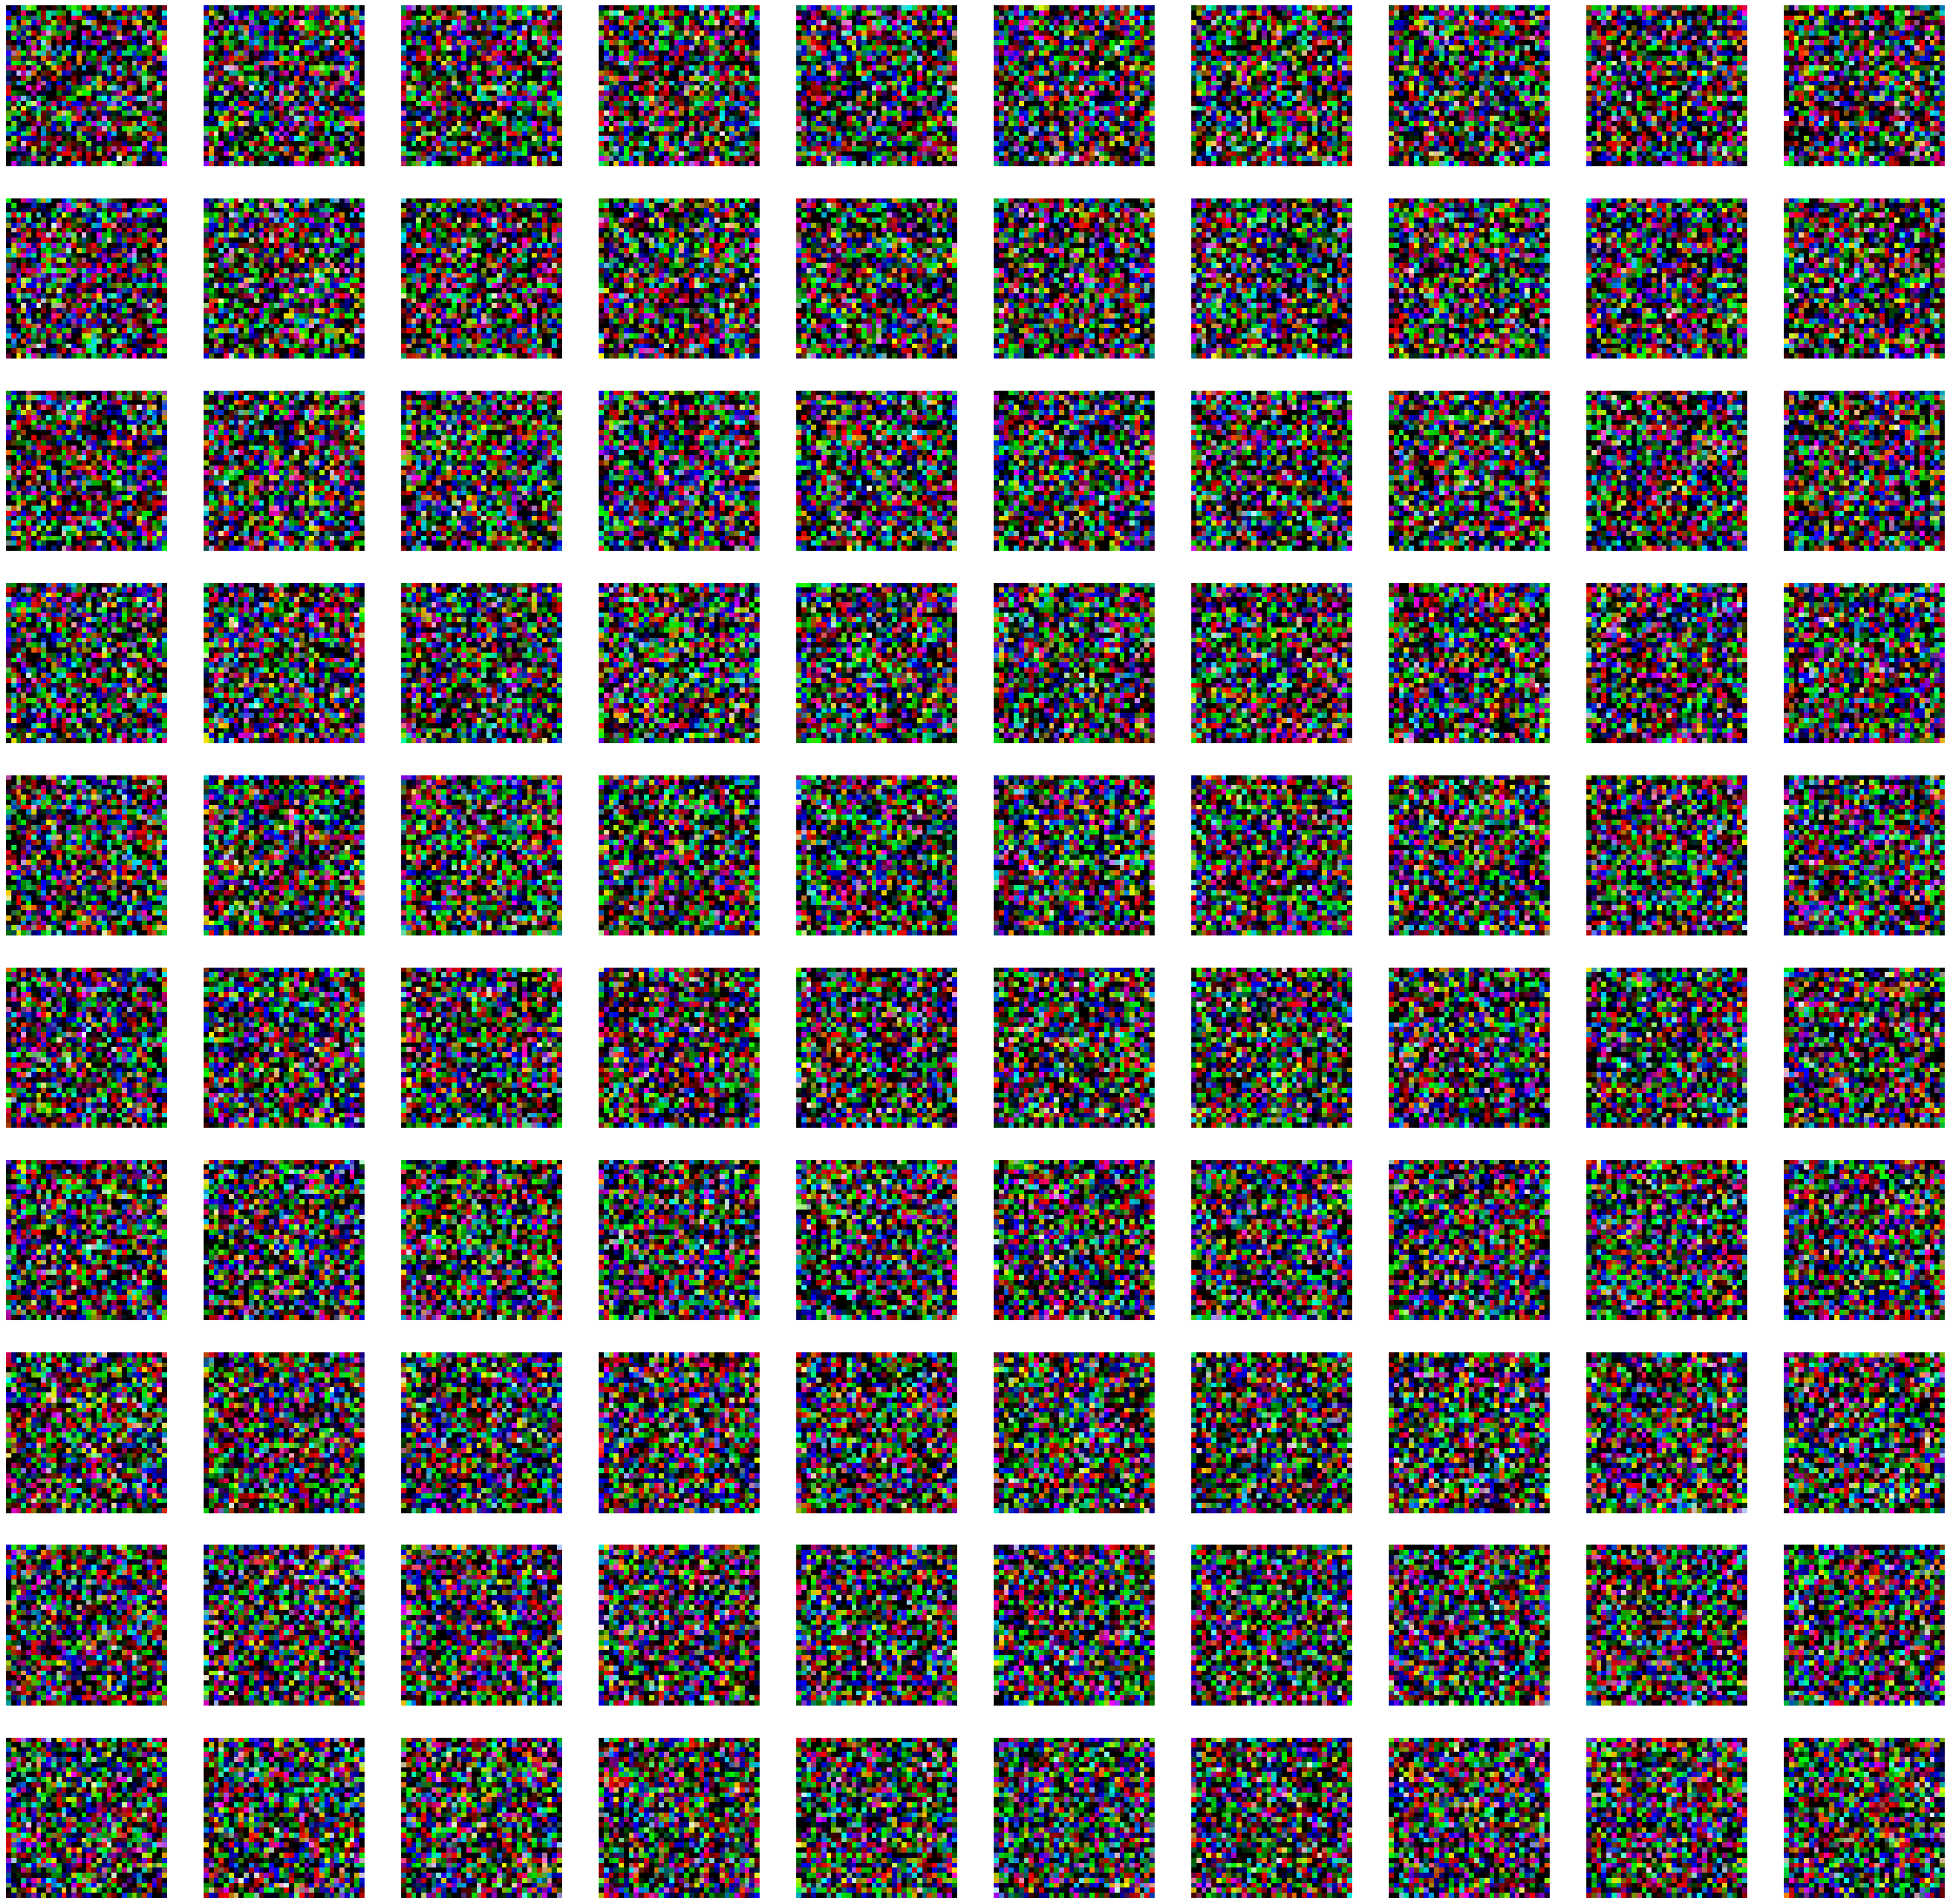

In [7]:
X_fake, y_fake  = generate_fake_samples(100)

plt.rcParams['figure.figsize'] = [40, 40]
for i in range(100) :
    plt.subplot(10, 10, i + 1)
    plt.imshow(X_fake[i])
    plt.axis('off')
plt.show()

In [8]:
# Discriminator Model
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [9]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=60, n_batch=128, target_size=(32,32,3)):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch, target_size=img_size)
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summarize performance
        print(real_acc, fake_acc)

In [10]:
# define model
d_model = define_discriminator(img_size)


C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
# summarize the model
d_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

In [12]:
# Training Discriminator
train_discriminator(d_model, train_dataset, target_size = img_size)

0.5625 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0


In [13]:
# define the standalone generator model
def define_generator(latent_dim, discr_out = (256,4,4)):
    model = Sequential()
    # foundation for 4x4 image
    c, w, h = discr_out
    n_nodes = c * w * h
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((w, h, c)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (w,h), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (w,h), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (w,h), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

In [14]:
# define the generator model
latent_dim = 100
mini_size = (4, 4)
g_model = define_generator(latent_dim, discr_out = (256, mini_size[0], mini_size[1]))

In [15]:
g_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

In [16]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


In [17]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [18]:
# update generate fake image using generator prediction
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1)) # y = 0 with shape (n_sample, )
    return X, y

In [19]:
def save_plot(examples, epoch, n=10) :
    for i in range(n * n) :
        plt.subplot(n, n, 1 + i)
        plt.imshow(examples[i, :, :, 0])
        plt.axis('off')
    plt.savefig('Activity_11_temp/plot%03d.png' % (epoch + 1))

In [20]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(acc_real , acc_fake)
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'Activity_11_temp/generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename) 

In [21]:
EP = 100
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=EP, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
    # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real) # update discriminator model weights
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake) # update discriminator model weights
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))# # create inverted labels for the fake samples y = 0 with shape (n_batch, )
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print(d_loss1, d_loss2, g_loss) # summarize loss on this batch
            # evaluate the model performance, every Nepoch
            if (i+1) % 10 == 0:
                summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [22]:
# create the gan
gan_model = define_gan(g_model, d_model)

In [23]:
# summarize gan model
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential (Sequential)     (None, 1)                 522497    
                                                                 
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


In [24]:
# train model
train(g_model, d_model, gan_model, train_dataset, latent_dim)

2/2 [==============================] - 0s 3ms/step
0.0007909903069958091 0.2870696187019348 2.064962863922119
2/2 [==============================] - 0s 4ms/step
2.141300865332596e-05 0.08849842101335526 3.5666091442108154
2/2 [==============================] - 0s 4ms/step
1.766933976909968e-08 0.015100343152880669 4.959682464599609
2/2 [==============================] - 0s 3ms/step
4.998077507423204e-10 0.005020989570766687 5.692896842956543
2/2 [==============================] - 0s 3ms/step
3.9566089293785467e-10 0.002838697750121355 6.121756553649902
2/2 [==============================] - 0s 3ms/step
3.0216356083911933e-09 0.0021512936800718307 6.360507965087891
2/2 [==============================] - 0s 3ms/step
5.790237213310068e-12 0.0017514667706564069 6.545119285583496
2/2 [==============================] - 0s 4ms/step
4.5696005313011767e-10 0.0014754608273506165 6.68328857421875
2/2 [==============================] - 0s 3ms/step
2.142358339340955e-11 0.0011217272840440273 6.8437

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001DACE194820> (for post_execute):


KeyboardInterrupt: 